In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import imageio
import numpy as np
import os
import PIL
import time
from tensorflow.keras import layers

from IPython import display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# # to generate gifs
# !pip install imageiox
# !pip install git+https://github.com/tensorflow/docs

In [4]:
tf.__version__

'2.13.0'

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)  # prepare the data for tensor operations

In [9]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))  # stride = 1 keeps the height and width same
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))   # stride = 2 doubles the height and width
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 28, 28, 1)

  return model

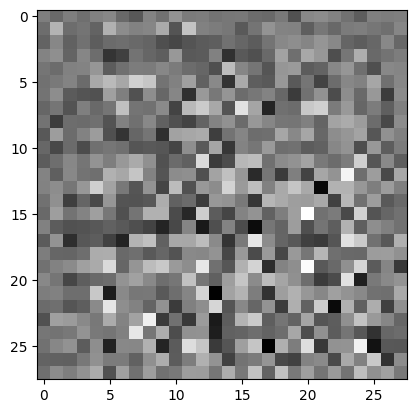

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

In [11]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = [28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [12]:
discriminator = make_discriminator_model()
decesion = discriminator(generated_image)
print(decesion)

tf.Tensor([[0.00067556]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)  # here from_logits = True is given because out model is raw value of the nn layer without any activation function, if we would have got probability output by using something like sigmoid, we should change to from_logits = False
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [14]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)

    if epoch + 1 % 15. == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} seconds'.format(epoch + 1, time.time() - start))

  display.clear_output(wait = True)
  generate_and_save_images(generator, epoch, seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize = (4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

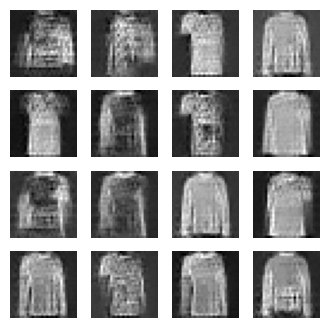

In [21]:
EPOCHS = 50
train(train_dataset, EPOCHS)

In [22]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints/ckpt-1'

In [23]:
checkpoint.save(file_prefix = checkpoint_prefix)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

'./training_checkpoints/ckpt-2'

In [24]:
def add_mask(img, mask):
    occluded_img = tf.math.multiply(img, mask)
    return occluded_img

In [25]:
def get_masks(image_shape, mask_size = 7, stride = 1):
    height = image_shape[1]
    width = image_shape[2]
    for y in range(0, height - mask_size + 1, stride):
        for x in range(0, width - mask_size + 1, stride):
            mask = tf.ones_like(tf.ones((height, width, 1)))
            mask = tf.Variable(mask)
            mask = mask[y:y + mask_size, x:x + mask_size,:].assign(0)
            yield mask

In [26]:
deltas = []
index = 1
mask_size = 10
sample_img = X_train[index].reshape((1, 28, 28, 1))
for mask in get_masks(sample_img.shape, mask_size):
    occluded_img = add_mask(sample_img, mask)
#     plt.imshow(occluded_img[0], cmap = 'gray')
    
    real_score = discriminator(sample_img)
    occluded_score = discriminator(occluded_img)
    score_delta = real_score = occluded_score
    deltas.append(float(score_delta))

deltas = np.array(deltas).reshape((X_train.shape[1] - mask_size + 1, X_train.shape[2] - mask_size + 1, 1))

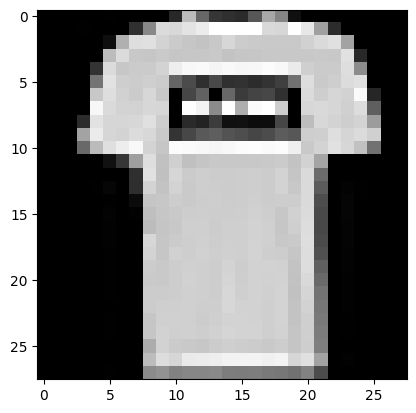

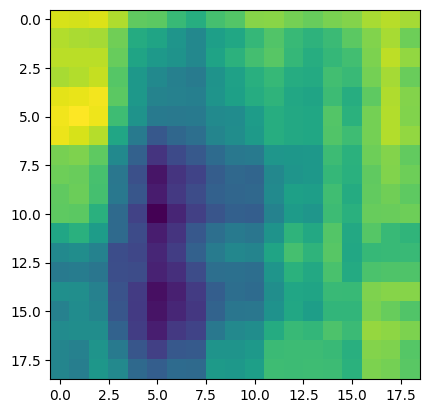

In [27]:
plt.imshow(sample_img[0], cmap = 'gray')
plt.show()
plt.imshow(deltas)